In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import PIL
from PIL import Image, ImageDraw
from collections import Counter
import cv2
import xml.etree.ElementTree as ET
%matplotlib inline

# WIDER dataset

Parse WIDER data file

In [2]:
wider_path = '/home/dmitrii/Work/Datasets/WIDERfacedet/'
wider_ims_path = wider_path + 'WIDER_train/images/'
with open(wider_path+'wider_face_split/wider_face_train_bbx_gt.txt') as f:
    wider_data = f.read().split('\n')
wider_data = [e for e in wider_data if len(e)>0]
i = 0
res = []
files = []
while (i<len(wider_data)):
    file = wider_data[i]
    index = int(file.split('--')[0])
    files.append(file)
    i+=1
    num = int(wider_data[i])
    i+=1
    for j in range(num):
        face = wider_data[i].split()
        res.append([index, file, num]+[int(e) for e in face])
        i+=1
wider_data=res

Make a dataframe

In [3]:
wider_train = pd.DataFrame(data=wider_data, columns=['category','filename','numfaces','x','y','w','h',
                                       'blur', 'expression', 'illumination', 'invalid', 'occlusion', 'pose'])
wider_train.head()

,category,filename,numfaces,x,y,w,h,blur,expression,illumination,invalid,occlusion,pose
0,0,0--Parade/0_Parade_marchingband_1_849.jpg,1,449,330,122,149,0,0,0,0,0,0
1,0,0--Parade/0_Parade_Parade_0_904.jpg,1,361,98,263,339,0,0,0,0,0,0
2,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,78,221,7,8,2,0,0,0,0,0
3,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,78,238,14,17,2,0,0,0,0,0
4,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,113,212,11,15,2,0,0,0,0,0


Get sizes of all images

In [4]:
res = []
for fn in files:
    im = Image.open(wider_ims_path+fn)
    width, height = im.size
    res.append([fn, width, height])

In [5]:
wider_sizes = pd.DataFrame(data=res, columns=['filename','imw','imh'])
wider_sizes.head()

,filename,imw,imh
0,0--Parade/0_Parade_marchingband_1_849.jpg,1024,1385
1,0--Parade/0_Parade_Parade_0_904.jpg,1024,1432
2,0--Parade/0_Parade_marchingband_1_799.jpg,1024,768
3,0--Parade/0_Parade_marchingband_1_117.jpg,1024,682
4,0--Parade/0_Parade_marchingband_1_778.jpg,1024,852


Add sizes to dataframe

In [6]:
wider_train = pd.merge(wider_train, wider_sizes, on='filename')

In [7]:
wider_train.head()

,category,filename,numfaces,x,y,w,h,blur,expression,illumination,invalid,occlusion,pose,imw,imh
0,0,0--Parade/0_Parade_marchingband_1_849.jpg,1,449,330,122,149,0,0,0,0,0,0,1024,1385
1,0,0--Parade/0_Parade_Parade_0_904.jpg,1,361,98,263,339,0,0,0,0,0,0,1024,1432
2,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,78,221,7,8,2,0,0,0,0,0,1024,768
3,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,78,238,14,17,2,0,0,0,0,0,1024,768
4,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,113,212,11,15,2,0,0,0,0,0,1024,768


Image width/height distribution:

Width of any image: {1024}
Typical height 736.4984501258922


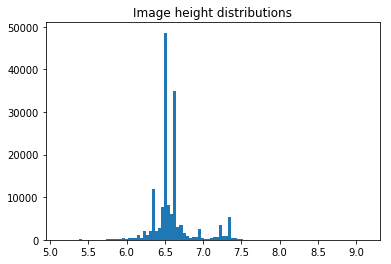

In [8]:
print('Width of any image: '+str(set(wider_train.imw)))
plt.hist(np.log(wider_train.imh), bins=100)
plt.title('Image height distributions')
print('Typical height', np.exp(np.mean(np.log(wider_train.imh))))
plt.show()

Typical face width/height:  17.503090129754213/22.303274222867483
Maximum face width:  976


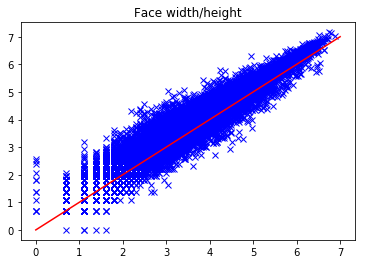

In [9]:
ind = (wider_train.w>0) & (wider_train.h>0)
print('Typical face width/height: ', str(np.exp(np.mean(np.log(wider_train.loc[ind].w)))) + 
      '/' + str(np.exp(np.mean(np.log(wider_train.loc[ind].h)))))
print('Maximum face width: ', max(wider_train.w))
plt.plot(np.log(wider_train.loc[ind].w), np.log(wider_train.loc[ind].h), 'bx')
plt.plot((0,7),(0,7),'r')
plt.title('Face width/height')
plt.show()

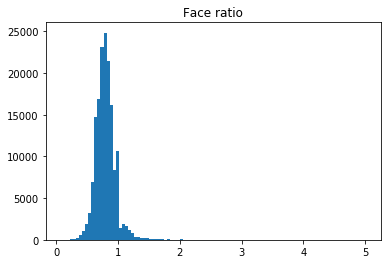

In [10]:
plt.hist(wider_train.loc[ind].w/wider_train.loc[ind].h, bins=100)
plt.title('Face ratio')
plt.show()

Mean face fraction (log):  0.017090523917050883
Mean face fraction:  0.02827372696258179


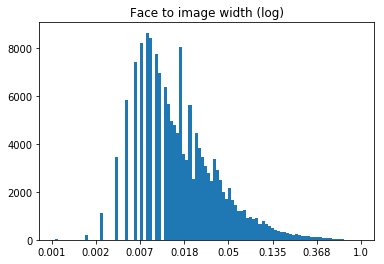

In [11]:
ind = wider_train.w>0
plt.hist(np.log(wider_train.loc[ind].w/wider_train.loc[ind].imw), bins=100)
plt.title('Face to image width (log)')
print('Mean face fraction (log): ', np.exp(np.mean(np.log(wider_train.loc[ind].w/wider_train.loc[ind].imw))))
print('Mean face fraction: ', np.mean(wider_train.loc[ind].w/wider_train.loc[ind].imw))
plt.xticks(np.arange(-7,1), np.round(np.exp(np.arange(-7,1)), 3))
plt.show()

A function to visualize data

In [12]:
def show_faces(db, path, file, showdb=False, lw=3, col='green', fs=12):
    faces = db.loc[db.filename==file]
    if showdb:
        dct = {'expression':'expr','illumination':'illum','invalid':'inv', 'occlusion':'occl'}
        print(faces.drop(['filename','numfaces','category',
                          'imw','imh'],axis=1,inplace=False).rename(columns=dct).reset_index())
    im = Image.open(path+file)
    draw = ImageDraw.Draw(im)
    for i in faces.index:
        x = db.loc[i,'x']
        y = db.loc[i,'y']
        w = db.loc[i,'w']
        h = db.loc[i,'h']
        #draw.rectangle([-10,-10,100,100], fill=tuple(np.array(im).mean(axis=(0,1)).astype(int)))
        draw.line([x,y,x+w,y,x+w,y+h,x,y+h,x,y], fill=col, width=lw)
    plt.figure(figsize=(fs,fs))
    plt.imshow(im)
    plt.show()

Heavy blur:

    index    x    y   w   h  blur  expr  illum  inv  occl  pose
0  159395  238  303  34  40     2     0      0    0     1     0
1  159396  347  305  33  38     2     0      0    0     0     0
2  159397  412  288  33  43     2     0      0    0     0     0
3  159398  501  292  41  51     2     0      0    0     0     0
4  159399  632  306  45  52     2     0      0    0     0     0
5  159400  747  278  43  56     1     0      0    0     0     0
6  159401  603  405  49  71     1     0      0    0     0     0
7  159402  431  407  38  64     2     0      0    0     0     1
8  159403  191  398  53  72     2     0      0    0     0     0
9  159404   77  390  37  63     2     0      0    0     0     1


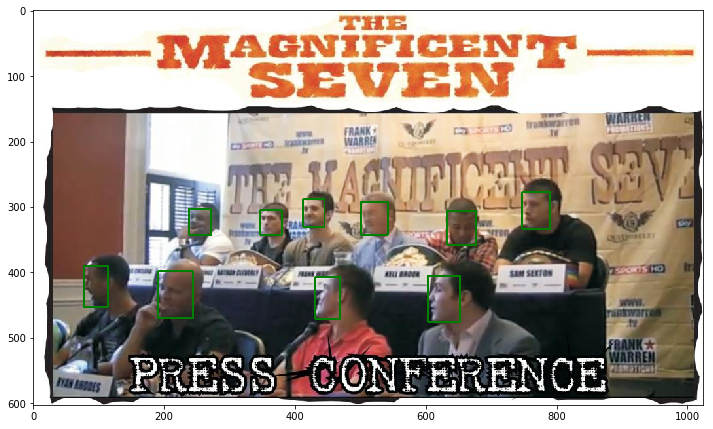

In [13]:
show_faces(wider_train, wider_ims_path, '9--Press_Conference/9_Press_Conference_Press_Conference_9_117.jpg', True)

Exaggerate expression:

   index    x    y    w    h  blur  expr  illum  inv  occl  pose
0  16166  732  320  160  230     0     0      0    0     0     0
1  16167  468  530   70   82     0     0      1    0     0     0
2  16168   78  456  108  146     0     1      1    0     0     0


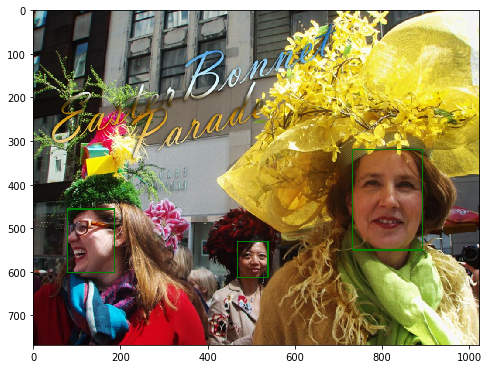

In [14]:
show_faces(wider_train, wider_ims_path, '0--Parade/0_Parade_Parade_0_395.jpg', True, fs=8)

Extreme illumination:

   index    x    y   w   h  blur  expr  illum  inv  occl  pose
0   5110  211  306  73  94     0     0      1    0     0     0
1   5111  973  349  42  69     0     0      0    0     0     0


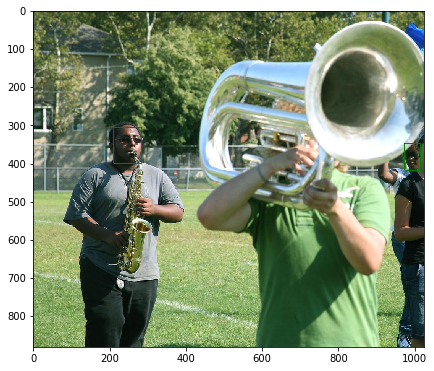

In [15]:
show_faces(wider_train, wider_ims_path, '0--Parade/0_Parade_marchingband_1_774.jpg', True, fs=7)

Invalid faces are always very small and sometimes false

   index    x    y   w   h  blur  expr  illum  inv  occl  pose
0  45931  590  456  14  24     2     0      0    0     0     0
1  45932  516  472   9  15     2     0      0    0     2     0
2  45933  643  452   7  11     2     0      0    0     2     0
3  45934  153  522   5   5     0     0      0    1     0     0


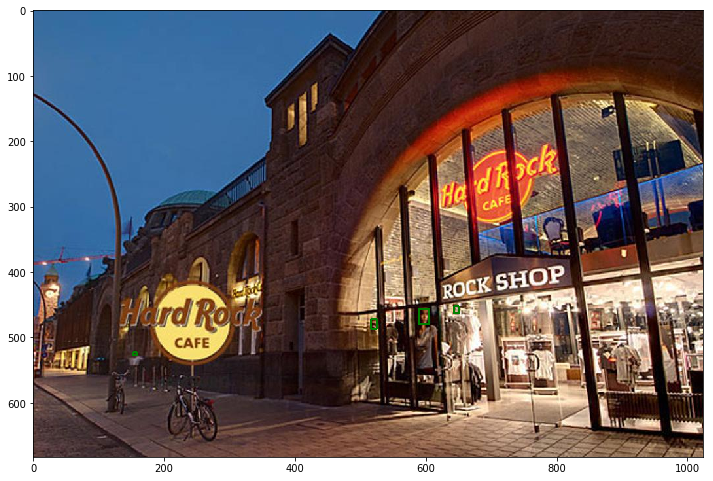

In [16]:
show_faces(wider_train, wider_ims_path, '18--Concerts/18_Concerts_Concerts_18_841.jpg', True, fs=12)

Maximum width and height for invalid faces

In [17]:
wider_train.loc[wider_train.invalid==1].max().loc[['w','h']]

w    10
h    10
dtype: object

Heavy occlusion

   index    x    y    w    h  blur  expr  illum  inv  occl  pose
0  15612  261  577  327  288     0     0      0    0     2     0
1  15613   27  480  309  324     0     0      0    0     2     0


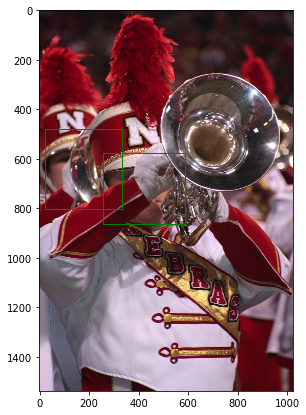

In [18]:
show_faces(wider_train, wider_ims_path, '0--Parade/0_Parade_marchingband_1_358.jpg', True, fs=7, lw=4)

Atypical pose

   index    x    y   w   h  blur  expr  illum  inv  occl  pose
0  10776  232  109  67  90     2     0      0    0     1     0
1  10777  681  167  56  74     2     0      0    0     1     1
2  10778  540  156  63  81     2     0      0    0     1     0


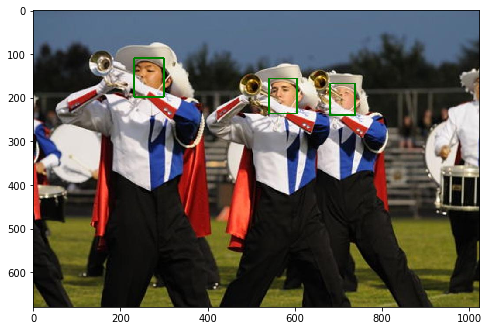

In [19]:
show_faces(wider_train, wider_ims_path, '0--Parade/0_Parade_marchingband_1_116.jpg', True, fs=8, lw=4)

Fractions of poor face images

In [20]:
c = Counter(wider_train.blur)
print('Blur: ', {k:v/sum(c.values()) for k,v in c.items()})
c = Counter(wider_train.occlusion)
print('Occlusion: ', {k:v/sum(c.values()) for k,v in c.items()})
c = Counter(wider_train.pose)
print('Pose: ', {k:v/sum(c.values()) for k,v in c.items()})
c = Counter(wider_train.illumination)
print('Illumination: ', {k:v/sum(c.values()) for k,v in c.items()})
c = Counter(wider_train.expression)
print('Expression: ', {k:v/sum(c.values()) for k,v in c.items()})
c = Counter(wider_train.invalid)
print('Invalid: ', {k:v/sum(c.values()) for k,v in c.items()})

Blur:  {0: 0.14298349056603774, 1: 0.25599031513448417, 2: 0.6010261942994781}
Occlusion:  {0: 0.6013147330389402, 1: 0.17456593737454837, 2: 0.22411932958651143}
Pose:  {0: 0.9621010638297872, 1: 0.03789893617021277}
Illumination:  {0: 0.948978823765556, 1: 0.051021176234444}
Expression:  {0: 0.9884270875150541, 1: 0.011572912484945805}
Invalid:  {0: 0.9849520774789241, 1: 0.015047922521075873}


Replace invalid width and height values

In [21]:
wider_train.loc[wider_train.w<=0, 'w'] = 1
wider_train.loc[wider_train.h<=0, 'h'] = 1

Make all faces square:

In [22]:
wider_corr = wider_train.copy()

ind = wider_corr.w<wider_corr.h
t = wider_corr.loc[ind]
ynew = t.y + (t.h-t.w)//2
wider_corr.loc[ind, 'h'] = wider_corr.loc[ind,'w']
wider_corr.loc[ind, 'y'] = ynew

ind = wider_corr.w>wider_corr.h
t = wider_corr.loc[ind]
xnew = t.x + (t.w-t.h)//2
wider_corr.loc[ind, 'w'] = wider_corr.loc[ind,'h']
wider_corr.loc[ind, 'x'] = xnew

wider_train = wider_corr

Resulting dataset:

In [23]:
wider_train.head()

,category,filename,numfaces,x,y,w,h,blur,expression,illumination,invalid,occlusion,pose,imw,imh
0,0,0--Parade/0_Parade_marchingband_1_849.jpg,1,449,343,122,122,0,0,0,0,0,0,1024,1385
1,0,0--Parade/0_Parade_Parade_0_904.jpg,1,361,136,263,263,0,0,0,0,0,0,1024,1432
2,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,78,221,7,7,2,0,0,0,0,0,1024,768
3,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,78,239,14,14,2,0,0,0,0,0,1024,768
4,0,0--Parade/0_Parade_marchingband_1_799.jpg,21,113,214,11,11,2,0,0,0,0,0,1024,768


Number of good faces:

In [24]:
wider_train.loc[(wider_train.w>10) & (wider_train.invalid==0)].shape[0]

107742

In [26]:
wider_train.to_csv('./data/wider.csv')

Check that created .xml files are correct (run "make wider_xml" to create them)

In [191]:
wider_path = '/home/dmitrii/Work/Datasets/WIDERfacedet/'
with open(wider_path+'trainval.txt') as f:
    data = f.read()
data = data.split('\n')
data = [e.split(' ') for e in data]

13--Interview/13_Interview_Interview_On_Location_13_132.jpg


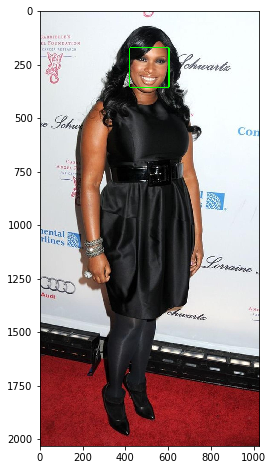

13--Interview/13_Interview_Interview_On_Location_13_132.jpg


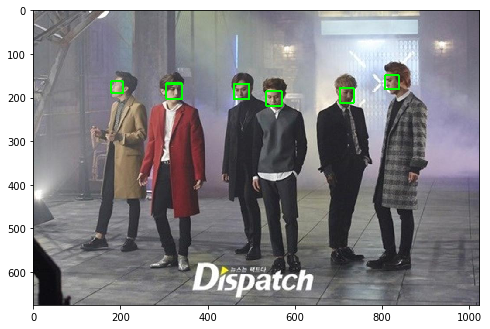

In [245]:
for ind in range(50,52):
    p_img, p_xml = data[ind]
    print(fn)
    
    img = cv2.imread(wider_path+p_img)

    e_anno = ET.parse(wider_path+p_xml).getroot()
    faces = e_anno.findall('object')
    faces = [e.find('bndbox') for e in faces]
    faces = [(int(e.find('xmin').text),
              int(e.find('ymin').text),
              int(e.find('xmax').text),
              int(e.find('ymax').text)) for e in faces]
    for face in faces:
        cv2.rectangle(img, (face[0],face[1]),(face[2],face[3]), (0,255,0), 3)

    plt.figure(figsize=(8,8))
    plt.imshow(img[:,:,::-1])
    plt.show()

# FDDB dataset

In [3]:
def parse_fddb(text, path, min_face=11):
    data = text.split('\n')
    data = [e for e in data if len(e)>0]
    i = 0
    res = []
    while (i<len(data)):
        file = data[i]
        im = Image.open(path+file+'.jpg')
        width, height = im.size
        channels = im.layers
        i+=1
        num = int(data[i])
        i+=1
        faces = []
        for j in range(num):
            face = data[i].split()
            face = [int(float(e)) for e in face if len(e)>0]
            rmax,rmin,ang,cx,cy,_ = face
            w = 2*rmin
            x = cx-rmin
            y = cy-rmin
            if w>=min_face:
                faces.append([x,y,x+w,y+w])
            i+=1
        if len(faces)>0:
            res.append((file+'.jpg', width, height, channels, faces))
    return res

In [10]:
fddb_path = '/home/dmitrii/Work/Datasets/FDDBfacedet/'
train_folds = ['01','02','03','04','06','07','08','09']
test_folds = ['05','10']

train_fddb = ''
for fld in train_folds:
    with open(fddb_path+'/FDDB-folds/FDDB-fold-'+fld+'-ellipseList.txt') as f:
        data = f.read()
        train_fddb = train_fddb+data
train_fddb = parse_fddb(train_fddb, fddb_path)

test_fddb = ''
for fld in test_folds:
    with open(fddb_path+'/FDDB-folds/FDDB-fold-'+fld+'-ellipseList.txt') as f:
        data = f.read()
        test_fddb = test_fddb+data
test_fddb = parse_fddb(test_fddb, fddb_path)

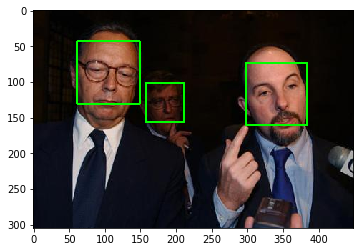

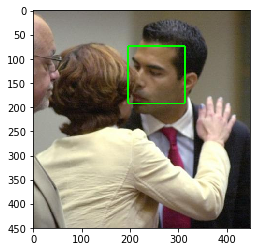

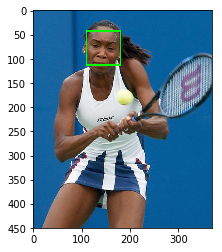

In [11]:
for item in train_fddb[1:4]:
    im = cv2.imread(fddb_path+item[0])

    for face in item[4]:
        cv2.rectangle(im, (face[0],face[1]), (face[2],face[3]), (0,255,0), 2)
    plt.imshow(im[:,:,::-1])
    plt.show()

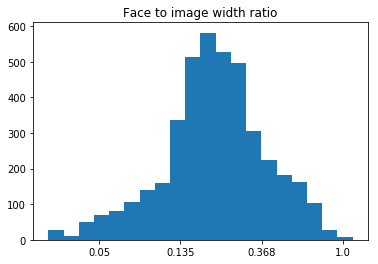

In [12]:
frac = []
for item in train_fddb:
    for f in item[4]:
        frac.append((f[2]-f[0])/item[1])
plt.hist(np.log(frac), bins=20)
plt.xticks([-3,-2,-1,0],np.round(np.exp([-3,-2,-1,0]),3))
plt.title('Face to image width ratio')
plt.show()

In [13]:
t = Image.open('./images/dogs.jpg')
t.layers

3